In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
reader = csv.reader(open("hepatitis_2_csv.csv", "r"))
x = list(reader)
res = np.array(x).astype("float")

In [247]:
training_class_name=res[0:568,19:20];
training_data=res[0:568,0:19];
training_data=np.matrix(training_data)
training_data=training_data.transpose()
training_class_name=np.matrix(training_class_name)
training_class_name=training_class_name.transpose()
print(np.prod(list(training_class_name[0].shape)))

568


In [8]:
meanData=training_data.mean()
varianceData=np.var(training_data)
training_data=(training_data-meanData)/varianceData

In [456]:
class Net:
    def __init__(self):
        self.weights=[];
        self.bias=[];
        self.status=[];
        self.a=[[]];
        self.z=[[]];
        self.da=[[]];
        self.dz=[[]];
        self.dw=[[]];
        self.db=[[]];
        self.cost=[];
        self.trainingOutput=[];
        self.correctOutput=[];
        
    def model(self,layers):
        self.layers=layers
        self.status.append("Model archetecture recieved")
        self.createBrain()
        self.status.append("Model archetecture created")
        return self.layers
    
    def createBrain(self):
        inputshape = self.layers[0].getshape()
        self.weights.append(0.01*np.random.rand(self.layers[1].getparams()["noOfUnits"],inputshape[0]))
        self.bias.append(np.ones([self.layers[1].getparams()["noOfUnits"],inputshape[1]]))
        print("layer 1 has bias shape as {} and weights shape as {}".format(self.bias[0].shape,self.weights[0].shape))
        for i in range(2,len(self.layers)):
            lowerlimit=self.layers[i].getparams()["noOfUnits"]
            upperlimit=self.layers[i-1].getparams()["noOfUnits"]
            self.weights.append(0.01*np.random.rand(lowerlimit,upperlimit))
            self.bias.append(np.ones([lowerlimit,inputshape[1]]))
            print("layer {} has bias shape as {} and weights shape as {}".format(i,self.bias[i-1].shape,self.weights[i-1].shape))
    
    def train(self,epochs,traindata,trainoutcome,LearningRate):
        self.epochs=np.asmatrix(np.arange(0,epochs,1))
        numberOfExamples = np.prod(list(training_class_name[0].shape))
        for i in range(0,epochs):
            val = self.forewardProp(numberOfExamples,traindata,trainoutcome,i)
            if(self.layers[1].getparams()["activation"]=="sigmoid"):
                val=val>=0.499
            elif(self.layers[1].getparams()["activation"]=="tanh" or self.layers[1].getparams()["activation"]=="relu"):
                val=val>=0
            self.trainingOutput.append(val)
            self.correctOutput.append(trainoutcome)
            self.status.append("Foreward Propogation for epoch {} is completed".format(i))
            self.backwardProp(numberOfExamples,trainoutcome,LearningRate,i)
            self.status.append("Backward Propogation for epoch {} is completed".format(i))
            self.da.append([])
            self.dz.append([])
            self.dw.append([])
            self.db.append([])
            self.a.append([])
            self.z.append([])
            
        #self.trainingOutput=np.asarray(self.trainingOutput)
        #self.correctOutput=np.asarray(self.correctOutput)
        #self.dz=np.asarray(self.dz)
        #self.dw=np.asarray(self.dw)
        #self.db=np.asarray(self.db)
        #self.da=np.asarray(self.da)

    
    def forewardProp(self,m,traindata,trainoutcome,iterno):
        self.a[iterno].append(traindata)
        #self.weights=np.asarray(self.weights)
        #self.bias=np.asarray(self.bias)
        z=np.dot(self.weights[0],traindata)+self.bias[0]
        self.z[iterno].append(z)
        
        if(self.layers[1].getparams()["activation"]=="sigmoid"):
            self.a[iterno].append(self.sigmoid(z))
        elif(self.layers[1].getparams()["activation"]=="tanh"):
            self.a[iterno].append(self.tanh(z))
        elif(self.layers[1].getparams()["activation"]=="relu"):
            self.a[iterno].append(self.relu(z))
            
        cost=self.costfunc(m,traindata,trainoutcome,self.a[iterno][1])
        cost=np.sum(cost)
        #print(self.bias[0])
        
        for i in range(2,len(self.layers)):
            z=np.dot(self.weights[i-1],self.a[iterno][i-1])+self.bias[i-1]
            self.z[iterno].append(z)
            if(self.layers[1].getparams()["activation"]=="sigmoid"):
                self.a[iterno].append(self.sigmoid(z))
            elif(self.layers[1].getparams()["activation"]=="tanh"):
                self.a[iterno].append(self.tanh(z))
            elif(self.layers[1].getparams()["activation"]=="relu"):
                self.a[iterno].append(self.relu(z))
        
            cost=cost+np.sum( self.costfunc(m,traindata,trainoutcome,self.a[iterno][i]) )
        self.cost.append(cost)
        #self.a[iterno] = self.a[iterno].reshape((1, len(self.layers)))
        print("cost for epoch {} is {}".format(iterno,self.cost[iterno]))

            
        return self.a[iterno][len(self.layers)-1]
     
    def costfunc(self,m,traindata,trainoutcome,res):
        A1=np.multiply(trainoutcome,np.log(res))
        A2=np.multiply((1-trainoutcome),np.log((1-res)))
        cost=A1+A2
        cost=np.sum(cost)
        cost=(-1/m)*cost
        return cost
    
    def backwardProp(self,m,trainoutcome,learningRate,iterno):
        AL=self.a[iterno][len(self.layers)-1]
        dAL= - ( np.divide(trainoutcome,AL) - np.divide(1-trainoutcome,1-AL) )
        self.da[iterno].append(dAL);
        for i in range(0,len(self.layers)-1): 
            sigmoidprime=self.sigmoid_Prime(self.z[iterno][len(self.layers)-2-i])
            dz = np.multiply(dAL,sigmoidprime)
            self.dz[iterno].append(dz)
            dw = (1/m) * ( dz * ( self.a[iterno][len(self.layers)-2-i].transpose() ) )
            self.dw[iterno].append(dw)
            dz = np.array(dz)
            db = (1/m)*np.sum(dz,axis=1,keepdims=True)
            db = np.asmatrix(db)
            dz = np.asmatrix(dz)
            self.db[iterno].append(db)
            dAL=(self.weights[len(self.layers)-2-i].transpose())*dz
            self.da[iterno].append(dAL)
            # Updating weights
            #print("dw is {}".format(dw))
            #print("db is {}".format(db))
            self.weights[len(self.layers)-2-i] = self.weights[len(self.layers)-2-i] - learningRate*dw
            self.bias[len(self.layers)-2-i] = self.bias[len(self.layers)-2-i] - learningRate*db
            #print("bias are {}".format(self.bias[len(self.layers)-2]))
                
    def sigmoid_Prime(self,value):
        part1=self.sigmoid(value)
        part2=1-(self.sigmoid(value))
        return np.multiply( part1 , part2 )
    
    def tanh_Prime(self,value):
        return 1-(self.tanh(value)*self.tanh(value))
    
    def relu_Prime(self,value):
        return value>=0
        
    def results(self):
        trainingOutput=np.asarray(self.trainingOutput)
        correctOutput=np.asarray(self.correctOutput)
        print(trainingOutput.shape,correctOutput.shape)
        #print(self.correctOutput.shape,self.trainingOutput.shape)
        ls=correctOutput - trainingOutput
        loss=np.sum(ls,axis=1)
        loss=loss/len(loss)
        ac=np.sum(correctOutput==trainingOutput,axis=1)
        accuracy=ac/len(self.correctOutput)
        plt.subplot(1,2,1)
        plt.plot(self.epochs.T,accuracy)
        plt.title("Training Accuracy")
        plt.xlabel("epochs")
        plt.ylabel("Accuracy")
        plt.subplot(1,2,2)
        plt.plot(self.epochs.T,loss)
        plt.title("Training Loss")
        plt.xlabel("epochs")
        plt.ylabel("Loss")
        #print("Accuracy : {}".format(accuracy[len(accuracy)-1]))
        #print("loss : {}".format(loss[len(loss)-1]))
    
    def sigmoid(self,X):
        return 1/(1+np.exp(-X));

    def tanh(self,X):
        return np.tanh(X);

    def relu(self,X):
        return np.maximum(0, X);

    def getActivation(self):
        # plot the activation function using matplotlib library
        cur_axes = plt.gca()
        # to remove the x axis
        cur_axes.axes.get_xaxis().set_visible(False)
        rangex=np.linspace(-10, 10, 100)

        if(self.activation=="sigmoid"):
            plt.plot(rangex,self.sigmoid(rangex))
        elif(self.activation=="tanh"):
            plt.plot(rangex,self.tanh(rangex))
        elif(self.activation=="relu"):
            plt.plot(rangex,self.relu(rangex))
            plt.title("activation function = "+self.activation)
        
    class Layers:
        
        class InputLayer:
            
            def __init__(self,shape):
                self.shape=shape
                
            def getshape(self):
                return np.asarray(self.shape).transpose()
        
        class DenseLayer:
            
            def __init__(self,noOfUnits,activation):
                self.params={"activation":activation,"shape":(noOfUnits,1),"noOfUnits":noOfUnits}
                
            def getparams(self):
                return self.params

In [457]:
my_brain = Net()
l1=Net.Layers.InputLayer(training_data.shape)
l2=Net.Layers.DenseLayer(15 , activation="sigmoid")
l3=Net.Layers.DenseLayer(10 , activation="sigmoid")
l4=Net.Layers.DenseLayer(5 , activation="sigmoid")
l5=Net.Layers.DenseLayer(4 , activation="sigmoid")
l6=Net.Layers.DenseLayer(1 , activation="sigmoid")
archetecture = my_brain.model(
    layers=[l1,l2,l3,l4,l5,l6]
)

layer 1 has bias shape as (15, 568) and weights shape as (15, 19)
layer 2 has bias shape as (10, 568) and weights shape as (10, 15)
layer 3 has bias shape as (5, 568) and weights shape as (5, 10)
layer 4 has bias shape as (4, 568) and weights shape as (4, 5)
layer 5 has bias shape as (1, 568) and weights shape as (1, 4)


In [458]:
my_brain.train(10,training_data,training_class_name,0.1)

cost for epoch 0 is 18.70278818312418
cost for epoch 1 is 18.687032996346634
cost for epoch 2 is 18.68356571931705
cost for epoch 3 is 18.68251921327333
cost for epoch 4 is 18.682136771903014
cost for epoch 5 is 18.681976704793165
cost for epoch 6 is 18.68190314990592
cost for epoch 7 is 18.68186726986375
cost for epoch 8 is 18.68184912184046
cost for epoch 9 is 18.681839735738567
cost for epoch 10 is 18.681834803881202
cost for epoch 11 is 18.68183217254998
cost for epoch 12 is 18.681830739657872
cost for epoch 13 is 18.68182993396256
cost for epoch 14 is 18.681829457310393
cost for epoch 15 is 18.68182915350553
cost for epoch 16 is 18.68182894055963
cost for epoch 17 is 18.681828775391725
cost for epoch 18 is 18.681828635352442
cost for epoch 19 is 18.681828508530653


(10, 1, 568) (10, 1, 568)


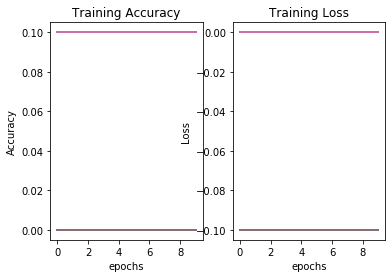

In [442]:
results=my_brain.results()

In [235]:
a=np.matrix([1,2,3,4,5,6,7,8,9])
print(a[0].shape)

(1, 9)
